# **Az egyéni feladataim a notebook végén találhatóak, a közösen elkészített munka után!<br>A kódban többször előfordulnak változónév-ismétlődések, ezért a kódblokkok egyesével történő futtatása nem megfelelő sorrendben hibás eredményekhez vezethet!**

# **Feladatleírás**

A projekt során egy felügyelt gépi tanulási problémát oldunk meg egy általunk tetszőlegesen választott adatbázison. A munkához egy banki adatbázist választottunk, amiben a bank az ügyfeleiről tárol el különféle adatokat. Ezek alapján azt szeretnénk megjósolni, hogy egy új ügyfél a jövőben fog-e betéti számlát nyitni.

# **Importok**

In [ ]:
import os
from zipfile import ZipFile
import urllib.request
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
recall_score, precision_score, f1_score, brier_score_loss)
from scipy.stats import binom_test
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier

# **Paraméterek**

In [ ]:
str_labels = ['job', 'marital', 'education', 'default', 'housing', 'loan']
int_labels = ['age', 'balance']
labels = str_labels + int_labels

empty_drop = True

train_size = 0.7
dev_size = 0.15
test_size = 1 - train_size - dev_size

# **Dataset**

Az adatokat egy linkből importáltuk be. Az így elért adatokat kicsomagoltuk és betöltöttük.

In [ ]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip'
urllib.request.urlretrieve(url, './bank.zip') 
with ZipFile('bank.zip', "r") as zipObj:
    zipObj.extractall()

bankdata_full = pd.read_csv("./bank-full.csv", delimiter=';')
# Tesztelesbol kiirjuk a beolvasott .csv fajl egyes reszeit
print("Adatrekordok szama: " + str(len(bankdata_full.index)))
print(np.sort((bankdata_full['age'].unique())))

Adatrekordok szama: 45211
[18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65
 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89
 90 92 93 94 95]


# **Adatfeldolgozás (MK - I)**

Megnéztük, hogy mennyi olyan sorunk van az adathalmazban, amiben van üres cella.

In [ ]:
for label in labels:
    i = 0
    for l in bankdata_full[label]:
        if l == "unknown":
            i += 1
    print(label + ": " + str(i))

job: 288
marital: 0
education: 1857
default: 0
housing: 0
loan: 0
age: 0
balance: 0


Majd ezeket kitöröltük.

In [ ]:
if empty_drop:
    for label in labels:
        for l in bankdata_full[label]:
            if l == "unknown":
                bankdata_dropped = bankdata_full.drop(bankdata_full.loc[bankdata_full[label] == "unknown"].index, inplace=False)
    print(bankdata_dropped)
else:
    pass
    # TODO: eldobás helyett valami más módszer az üres cellát tartalmazó sorok kezelésére

       age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
5       35    management   married   tertiary      no      231     yes   no   
6       28    management    single   tertiary      no      447     yes  yes   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day month  duration  campaign  pd

In [ ]:
bankdata_dropped['loan'].value_counts()

no     36243
yes     7111
Name: loan, dtype: int64

**Ordial Encoder**

In [ ]:
encoded_str = bankdata_dropped[str_labels]

oe = preprocessing.OrdinalEncoder()
encoded_str[str_labels] = oe.fit_transform(encoded_str[str_labels])

print(encoded_str)

       job  marital  education  default  housing  loan
0      4.0      1.0        2.0      0.0      1.0   0.0
1      9.0      2.0        1.0      0.0      1.0   0.0
2      2.0      1.0        1.0      0.0      1.0   1.0
5      4.0      1.0        2.0      0.0      1.0   0.0
6      4.0      2.0        2.0      0.0      1.0   1.0
...    ...      ...        ...      ...      ...   ...
45206  9.0      1.0        2.0      0.0      0.0   0.0
45207  5.0      0.0        0.0      0.0      0.0   0.0
45208  5.0      1.0        1.0      0.0      0.0   0.0
45209  1.0      1.0        1.0      0.0      0.0   0.0
45210  2.0      1.0        1.0      0.0      0.0   0.0

[43354 rows x 6 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


**MinMax Scaler**

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
encoded_str[str_labels] = min_max_scaler.fit_transform(encoded_str[str_labels])

print(encoded_str)

            job  marital  education  default  housing  loan
0      0.363636      0.5        1.0      0.0      1.0   0.0
1      0.818182      1.0        0.5      0.0      1.0   0.0
2      0.181818      0.5        0.5      0.0      1.0   1.0
5      0.363636      0.5        1.0      0.0      1.0   0.0
6      0.363636      1.0        1.0      0.0      1.0   1.0
...         ...      ...        ...      ...      ...   ...
45206  0.818182      0.5        1.0      0.0      0.0   0.0
45207  0.454545      0.0        0.0      0.0      0.0   0.0
45208  0.454545      0.5        0.5      0.0      0.0   0.0
45209  0.090909      0.5        0.5      0.0      0.0   0.0
45210  0.181818      0.5        0.5      0.0      0.0   0.0

[43354 rows x 6 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


**Standard Scaler**

In [ ]:
encoded_int = bankdata_dropped[int_labels]

ss = preprocessing.StandardScaler()
encoded_int[int_labels] = ss.fit_transform(encoded_int[int_labels])

print(encoded_int)

            age   balance
0      1.636763  0.259146
1      0.305821 -0.436276
2     -0.739919 -0.445158
5     -0.549785 -0.369826
6     -1.215256 -0.298770
...         ...       ...
45206  0.971292 -0.174423
45207  2.872638  0.122957
45208  2.967705  1.434192
45209  1.541696 -0.226070
45210 -0.359650  0.531525

[43354 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


**Ellenőrzésképp átlag és szórás kiszámolása**

In [ ]:
print(np.mean(encoded_int['age'],axis=0))
print(np.std(encoded_int['age'],axis=0))

-1.1595856186710912e-15
1.0000000000000047


**Elkészült adatoszlopok összefűzése**

In [ ]:
encoded_full = pd.concat([encoded_str, encoded_int], axis=1)
print(encoded_full)

            job  marital  education  default  housing  loan       age  \
0      0.363636      0.5        1.0      0.0      1.0   0.0  1.636763   
1      0.818182      1.0        0.5      0.0      1.0   0.0  0.305821   
2      0.181818      0.5        0.5      0.0      1.0   1.0 -0.739919   
5      0.363636      0.5        1.0      0.0      1.0   0.0 -0.549785   
6      0.363636      1.0        1.0      0.0      1.0   1.0 -1.215256   
...         ...      ...        ...      ...      ...   ...       ...   
45206  0.818182      0.5        1.0      0.0      0.0   0.0  0.971292   
45207  0.454545      0.0        0.0      0.0      0.0   0.0  2.872638   
45208  0.454545      0.5        0.5      0.0      0.0   0.0  2.967705   
45209  0.090909      0.5        0.5      0.0      0.0   0.0  1.541696   
45210  0.181818      0.5        0.5      0.0      0.0   0.0 -0.359650   

        balance  
0      0.259146  
1     -0.436276  
2     -0.445158  
5     -0.369826  
6     -0.298770  
...         ...

**Adathalmaz felosztása**

In [ ]:
train, dev, test = np.split(encoded_full.sample(frac=1, random_state=123456),
                            [int(train_size*len(encoded_full)), int((train_size+dev_size)*len(encoded_full))])
print("Train size: " + str(train.size // 8))
print("Dev size: " + str(dev.size // 8))
print("Test size: " + str(test.size // 8))

Train size: 30347
Dev size: 6503
Test size: 6504


In [ ]:
x_train = train.drop(columns=['loan'])
y_train = train['loan']

x_dev = dev.drop(columns=['loan'])
y_dev = dev['loan']

x_test = test.drop(columns=['loan'])
y_test = test['loan']

# **Modellezés (MK - II)**

**Kiértékelő függvények a tanító és a teszt halmazra, amikben különböző metrikákkal vizsgálhatjuk tanításaink sikerességét**

In [ ]:
def evaluate_train():

    print(y_train.value_counts(), "\n")
    unique, counts = np.unique(pred_train, return_counts=True)

    print(dict(zip(unique, counts)),  "\n")

    test_accuracy_score = accuracy_score(y_train, pred_train)
    print('train - accuracy_score: ', test_accuracy_score)

    '''
    n_success = np.sum(y_test == pred)
    p = 0.90
    interval = binom_test(n_success, y_test.shape[0], p=p)
    print("Test-acc: ", acc, "+/-", interval, "(", p*100, "%)")
    '''

    test_balanced_accuracy_score = balanced_accuracy_score(y_train, pred_train)
    print('train - balanced_accuracy_score: ', test_balanced_accuracy_score)

    test_recall_score = recall_score(y_train, pred_train)
    print('train - recall_score: ', test_recall_score)

    test_precision_score = precision_score(y_train, pred_train, zero_division=0)
    print('train - preision_score: ', test_precision_score)

    test_f1_score = f1_score(y_train, pred_train)
    print('train - f1_score: ', test_f1_score)

    test_brier_score_loss = brier_score_loss(y_train, pred_train)
    print('train - brier_score_loss: ', test_brier_score_loss)

    print()

In [ ]:
def evaluate_test():

    print(y_test.value_counts(), "\n")
    unique, counts = np.unique(pred_test, return_counts=True)

    print(dict(zip(unique, counts)),  "\n")

    test_accuracy_score = accuracy_score(y_test, pred_test)
    print('test - accuracy_score: ', test_accuracy_score)

    '''
    n_success = np.sum(y_test == pred)
    p = 0.90
    interval = binom_test(n_success, y_test.shape[0], p=p)
    print("Test-acc: ", acc, "+/-", interval, "(", p*100, "%)")
    '''

    test_balanced_accuracy_score = balanced_accuracy_score(y_test, pred_test)
    print('test - balanced_accuracy_score: ', test_balanced_accuracy_score)

    test_recall_score = recall_score(y_test, pred_test)
    print('test - recall_score: ', test_recall_score)

    test_precision_score = precision_score(y_test, pred_test, zero_division=0)
    print('test - preision_score: ', test_precision_score)

    test_f1_score = f1_score(y_test, pred_test)
    print('test - f1_score: ', test_f1_score)

    test_brier_score_loss = brier_score_loss(y_test, pred_test)
    print('test - brier_score_loss: ', test_brier_score_loss)

    print()

**Baseline (Constant)**

In [ ]:
base_line = DummyClassifier(strategy='constant', constant=1.0)
base_line.fit(x_train, y_train)

pred_train = base_line.predict(train)
pred_test = base_line.predict(test)

evaluate_train()
evaluate_test()

0.0    25386
1.0     4961
Name: loan, dtype: int64 

{1.0: 30347} 

train - accuracy_score:  0.1634757966191057
train - balanced_accuracy_score:  0.5
train - recall_score:  1.0
train - preision_score:  0.1634757966191057
train - f1_score:  0.2810128016313584
train - brier_score_loss:  0.8365242033808943

0.0    5448
1.0    1056
Name: loan, dtype: int64 

{1.0: 6504} 

test - accuracy_score:  0.16236162361623616
test - balanced_accuracy_score:  0.5
test - recall_score:  1.0
test - preision_score:  0.16236162361623616
test - f1_score:  0.27936507936507937
test - brier_score_loss:  0.8376383763837638



**Baseline (Random)**

In [ ]:
pred_train = np.random.randint(0, 2, size=(1, len(y_train)))[0]
pred_test = np.random.randint(0, 2, size=(1, len(y_test)))[0]

evaluate_train()
evaluate_test()

0.0    25386
1.0     4961
Name: loan, dtype: int64 

{0: 15173, 1: 15174} 

train - accuracy_score:  0.5016640854120671
train - balanced_accuracy_score:  0.5030624437460057
train - recall_score:  0.5051400927232412
train - preision_score:  0.16515091604059576
train - f1_score:  0.24891979140799603
train - brier_score_loss:  0.4983359145879329

0.0    5448
1.0    1056
Name: loan, dtype: int64 

{0: 3291, 1: 3213} 

test - accuracy_score:  0.5044587945879458
test - balanced_accuracy_score:  0.5007529869176345
test - recall_score:  0.4952651515151515
test - preision_score:  0.16277622159975103
test - f1_score:  0.24502225345514175
test - brier_score_loss:  0.4955412054120541



**Baseline (Random with given distribution)**

In [ ]:
pred_train = np.random.choice(2, len(pred_train), p=[0.83, 0.17])
pred_test = np.random.choice(2, len(pred_test), p=[0.83, 0.17])

evaluate_train()
evaluate_test()

0.0    25386
1.0     4961
Name: loan, dtype: int64 

{0: 25166, 1: 5181} 

train - accuracy_score:  0.71852242396283
train - balanced_accuracy_score:  0.49434118782296443
train - recall_score:  0.16125781092521668
train - preision_score:  0.15441034549314805
train - f1_score:  0.15775981068822717
train - brier_score_loss:  0.28147757603717005

0.0    5448
1.0    1056
Name: loan, dtype: int64 

{0: 5392, 1: 1112} 

test - accuracy_score:  0.7177121771217713
test - balanced_accuracy_score:  0.4917776331597918
test - recall_score:  0.1571969696969697
test - preision_score:  0.14928057553956833
test - f1_score:  0.15313653136531363
test - brier_score_loss:  0.2822878228782288



**Baseline (Most Frequent)**

In [ ]:
base_line = DummyClassifier(strategy='most_frequent')
base_line.fit(x_train, y_train)

pred_train = base_line.predict(train)
pred_test = base_line.predict(test)

evaluate_train()
evaluate_test()

0.0    25386
1.0     4961
Name: loan, dtype: int64 

{0.0: 30347} 

train - accuracy_score:  0.8365242033808943
train - balanced_accuracy_score:  0.5
train - recall_score:  0.0
train - preision_score:  0.0
train - f1_score:  0.0
train - brier_score_loss:  0.1634757966191057

0.0    5448
1.0    1056
Name: loan, dtype: int64 

{0.0: 6504} 

test - accuracy_score:  0.8376383763837638
test - balanced_accuracy_score:  0.5
test - recall_score:  0.0
test - preision_score:  0.0
test - f1_score:  0.0
test - brier_score_loss:  0.16236162361623616



**Gaussian Naive-Bayes**

In [ ]:
model = GaussianNB()
model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

evaluate_train()
evaluate_test()

0.0    25386
1.0     4961
Name: loan, dtype: int64 

{0.0: 29792, 1.0: 555} 

train - accuracy_score:  0.8322733713381882
train - balanced_accuracy_score:  0.5147314498610314
train - recall_score:  0.042934892158838944
train - preision_score:  0.3837837837837838
train - f1_score:  0.0772298767222625
train - brier_score_loss:  0.1677266286618117

0.0    5448
1.0    1056
Name: loan, dtype: int64 

{0.0: 6385, 1.0: 119} 

test - accuracy_score:  0.8322570725707257
test - balanced_accuracy_score:  0.5128195501268188
test - recall_score:  0.03977272727272727
test - preision_score:  0.35294117647058826
test - f1_score:  0.07148936170212765
test - brier_score_loss:  0.1677429274292743



**Gaussian Mixture Model**

In [ ]:
def make_prediction(gmms, x):
    n_samples = x.shape[0]
    p_test = np.zeros(n_samples)
    for i in range(n_samples):
        pred_val = -np.inf
        for c_idx in range(len(gmms)):
            dense_val = gmms[c_idx].score(x[i:(i+1)])
            if dense_val > pred_val:
                p_test[i]=c_idx
                pred_val=dense_val
    return p_test

#cov_type = 'spherical'
#cov_type = 'full'
#cov_type = 'diag'
cov_type = 'tied'
n_components = 1
gmm_models = {0:GaussianMixture(n_components=n_components, covariance_type=cov_type),
              1:GaussianMixture(n_components=n_components, covariance_type=cov_type)}

for (c_idx, model) in gmm_models.items():
    #print(x_train[y_train == c_idx].shape)
    model.fit(x_train[y_train == c_idx])

pred_train = make_prediction(gmm_models, x_train)
#print('train_acc: ', accuracy_score(y_train, pred_train))
pred_test = make_prediction(gmm_models, x_test)
#print('test_acc: ', accuracy_score(y_test, pred_test))

evaluate_train()
evaluate_test()

0.0    25386
1.0     4961
Name: loan, dtype: int64 

{0.0: 20176, 1.0: 10171} 

train - accuracy_score:  0.6507068243977988
train - balanced_accuracy_score:  0.5726853217802714
train - recall_score:  0.4567627494456763
train - preision_score:  0.22279028610756071
train - f1_score:  0.2994977531060006
train - brier_score_loss:  0.3492931756022012

0.0    5448
1.0    1056
Name: loan, dtype: int64 

{0.0: 4354, 1.0: 2150} 

test - accuracy_score:  0.6420664206642066
test - balanced_accuracy_score:  0.5508297456948338
test - recall_score:  0.41571969696969696
test - preision_score:  0.20418604651162792
test - f1_score:  0.27386150966936995
test - brier_score_loss:  0.35793357933579334



**K Nearest Neighbour**

In [ ]:
k = 2
knn = KNeighborsClassifier(n_neighbors = k)

knn.fit(x_train, y_train)

pred_train = knn.predict(x_train)
pred_test = knn.predict(x_test)

evaluate_train()
evaluate_test()

0.0    25386
1.0     4961
Name: loan, dtype: int64 

{0.0: 29063, 1.0: 1284} 

train - accuracy_score:  0.8787030019441789
train - balanced_accuracy_score:  0.629168429213079
train - recall_score:  0.25841564200765976
train - preision_score:  0.9984423676012462
train - f1_score:  0.4105684547638111
train - brier_score_loss:  0.121296998055821

0.0    5448
1.0    1056
Name: loan, dtype: int64 

{0.0: 6276, 1.0: 228} 

test - accuracy_score:  0.826260762607626
test - balanced_accuracy_score:  0.5226000367107195
test - recall_score:  0.07291666666666667
test - preision_score:  0.33771929824561403
test - f1_score:  0.11993769470404986
test - brier_score_loss:  0.17373923739237393



**GridSearch a legjobb szomszédsági szám megtalálásához**

In [ ]:
tuned_parameters = [{'n_neighbors': range(21)}]
scoring='accuracy'
base_model = KNeighborsClassifier()
clf = GridSearchCV(base_model, tuned_parameters, cv=5, scoring=scoring,
                   return_train_score=True, refit=True)
clf.fit(x_train, y_train)
print("Best parameters set found on development set:\n")
print(clf.best_params_)
print("\nGrid scores on development set:\n")
val_means = clf.cv_results_['mean_test_score']
val_stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(val_means, val_stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Best parameters set found on development set:

{'n_neighbors': 20}

Grid scores on development set:

nan (+/-nan) for {'n_neighbors': 0}
0.758 (+/-0.006) for {'n_neighbors': 1}
0.821 (+/-0.004) for {'n_neighbors': 2}
0.794 (+/-0.004) for {'n_neighbors': 3}
0.826 (+/-0.005) for {'n_neighbors': 4}
0.815 (+/-0.003) for {'n_neighbors': 5}
0.830 (+/-0.003) for {'n_neighbors': 6}
0.824 (+/-0.003) for {'n_neighbors': 7}
0.832 (+/-0.002) for {'n_neighbors': 8}
0.828 (+/-0.003) for {'n_neighbors': 9}
0.834 (+/-0.001) for {'n_neighbors': 10}
0.831 (+/-0.003) for {'n_neighbors': 11}
0.835 (+/-0.003) for {'n_neighbors': 12}
0.833 (+/-0.004) for {'n_neighbors': 13}
0.835 (+/-0.002) for {'n_neighbors': 14}
0.835 (+/-0.003) for {'n_neighbors': 15}
0.836 (+/-0.002) for {'n_neighbors': 16}
0.835 (+/-0.003) for {'n_neighbors': 17}
0.836 (+/-0.001) for {'n_neighbors': 18}
0.835 (+/-0.002) for {'n_neighbors': 19}
0.836 (+/-0.001) for {'n_neighbors': 20}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 105.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py", line 198, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py", line 569, in _fit
    raise ValueError("Expected n_neighbors > 0. Got %d" % self.n_neighbors)
ValueError: Expecte

**Nearest Centroid**

In [ ]:
nc = NearestCentroid()
nc.fit(x_train, y_train)

pred_train = nc.predict(x_train)
pred_test = nc.predict(x_test)

evaluate_train()
evaluate_test()

0.0    25386
1.0     4961
Name: loan, dtype: int64 

{0.0: 10661, 1.0: 19686} 

train - accuracy_score:  0.4352324776748937
train - balanced_accuracy_score:  0.5645561337623568
train - recall_score:  0.7567022777665793
train - preision_score:  0.19069389413796606
train - f1_score:  0.3046212520793605
train - brier_score_loss:  0.5647675223251063

0.0    5448
1.0    1056
Name: loan, dtype: int64 

{0.0: 2293, 1.0: 4211} 

test - accuracy_score:  0.43219557195571956
test - balanced_accuracy_score:  0.5583888165798958
test - recall_score:  0.7452651515151515
test - preision_score:  0.18689147470909523
test - f1_score:  0.29884184545281944
test - brier_score_loss:  0.5678044280442804



# **Egyéni feladatok (MK - III)**

## **Feladat 1:<br>GRP, PCA és LDA használata PipeLine felhasználásával**

**Szükséges importok**

In [ ]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.random_projection import GaussianRandomProjection
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

def display(x,y):
    colors=['red','gold']
    for idx,c in enumerate(colors):
        plt.scatter(x[y==idx,0],x[y==idx,1],c=c,label=str(idx))
    plt.legend()

**Gaussian Random Projection**

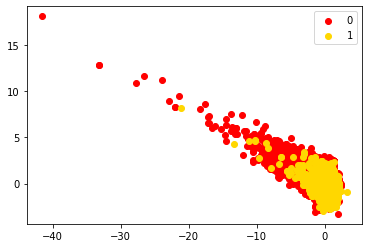

In [ ]:
grp = GaussianRandomProjection(n_components=2)
x_transformed = grp.fit_transform(x_train)

display(x_transformed,y_train)

In [ ]:
model = GaussianNB()
model.fit(x_train, y_train)

print('Base train score:', model.score(x_train, y_train))
print('Base test score:', model.score(x_test, y_test))
print()

grp = GaussianRandomProjection(n_components=2)
model = GaussianNB()
pipe = Pipeline(steps=[('grp', grp), ('gnb', model)])
pipe.fit(x_train, y_train)

print('GRP train score:', pipe.score(x_train, y_train))
print('GRP test score:', pipe.score(x_test, y_test))

Base train score: 0.8322733713381882
Base test score: 0.8322570725707257

GRP train score: 0.8365242033808943
GRP test score: 0.8376383763837638


**Principal component analysis**

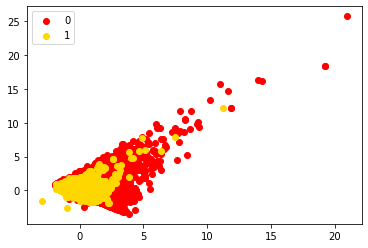

In [ ]:
pca = PCA(n_components=2)
x_transformed = pca.fit_transform(x_train)

display(x_transformed, y_train)

In [ ]:
model = GaussianNB()
model.fit(x_train, y_train)

print('Base train score:', model.score(x_train, y_train))
print('Base test score:', model.score(x_test, y_test))
print()

pca = PCA(n_components=2)
model = GaussianNB()
pipe = Pipeline(steps=[('pca', pca), ('gnb', model)])
pipe.fit(x_train, y_train)

print('PCA train score:', pipe.score(x_train, y_train))
print('PCA test score:', pipe.score(x_test, y_test))

Base train score: 0.8322733713381882
Base test score: 0.8322570725707257

PCA train score: 0.8365242033808943
PCA test score: 0.8376383763837638


**Linear Discriminant Analysis**

In [ ]:
# mivel csak két különböző osztályunk van,
# ezért LDA-val csakis pontosan 1 komponenst tudunk létrehozni
lda = LinearDiscriminantAnalysis(n_components=1)
x_transformed = lda.fit_transform(x_train, y_train)
print(x_transformed)

[[-0.54800697]
 [ 0.13839926]
 [ 0.05650552]
 ...
 [ 0.00664518]
 [ 0.2540141 ]
 [-0.41606978]]


In [ ]:
model = GaussianNB()
model.fit(x_train, y_train)

print('Base train score:', model.score(x_train, y_train))
print('Base test score:', model.score(x_test, y_test))
print()

lda = LinearDiscriminantAnalysis(n_components=1)
model = GaussianNB()
pipe = Pipeline(steps=[('lda', lda), ('gnb', model)])
pipe.fit(x_train, y_train)

print('LDA train score:', pipe.score(x_train, y_train))
print('LDA test score:', pipe.score(x_test, y_test))

Base train score: 0.8322733713381882
Base test score: 0.8322570725707257

LDA train score: 0.8312189013741061
LDA test score: 0.8308733087330873


## **Feladat 2:<br>Legjobb módszerek tesztelése kiegyensúlyozott adatbázison**

**Adatok beolvasása**

In [ ]:
url = ('https://archive.ics.uci.edu/ml/machine-learning-databases/'
        '00267/data_banknote_authentication.txt')

banknote_full = pd.read_csv(url, delimiter=',', header=None)

# Tesztelesbol kiirjuk a beolvasott .csv fajl egyes reszeit
print("Adatrekordok szama: " + str(len(banknote_full.index)))
print(np.sort((banknote_full[1].unique())))
print(banknote_full[4].value_counts())
banknote_full

Adatrekordok szama: 1372
[-13.7731 -13.6779 -13.6593 ...  12.6247  12.7302  12.9516]
0    762
1    610
Name: 4, dtype: int64


,0,1,2,3,4
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


**Jól látható, hogy ez már egy sokkal kiegyensúlyozottabb adatbázis, mint amit korábban használtunk.**

In [ ]:
# hiányos adatsorok megszámlálása
for col in range(0,5):
    i = 0
    for l in banknote_full[col]:
        if l == None:
            i += 1
    print(str(col) + ": " + str(i))

0: 0
1: 0
2: 0
3: 0
4: 0


**A jellemzővektoraink nem hiányosak, azonban értéktartományukat érdemes lehet csökkenteni.**

In [ ]:
banknote = banknote_full
int_labels = [0, 1, 2, 3]

encoded_int = banknote[int_labels]

ss = preprocessing.StandardScaler()
encoded_int[int_labels] = ss.fit_transform(encoded_int[int_labels])

print(encoded_int)

             0         1         2         3
0     1.121806  1.149455 -0.975970  0.354561
1     1.447066  1.064453 -0.895036 -0.128767
2     1.207810 -0.777352  0.122218  0.618073
3     1.063742  1.295478 -1.255397 -1.144029
4    -0.036772 -1.087038  0.736730  0.096587
...        ...       ...       ...       ...
1367 -0.009711 -0.097693 -0.660962  0.300996
1368 -0.641313 -1.158984  1.179023  0.730127
1369 -1.472357 -2.621646  3.759017 -0.754884
1370 -1.406693 -1.756471  2.552043 -0.043158
1371 -1.047122 -0.439822  0.298616  1.136464

[1372 rows x 4 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


**Jellemzők és címkék összefűzése**

In [ ]:
encoded_label = banknote[4]
encoded_full = pd.concat([encoded_int, encoded_label], axis=1)
print(encoded_full)

             0         1         2         3  4
0     1.121806  1.149455 -0.975970  0.354561  0
1     1.447066  1.064453 -0.895036 -0.128767  0
2     1.207810 -0.777352  0.122218  0.618073  0
3     1.063742  1.295478 -1.255397 -1.144029  0
4    -0.036772 -1.087038  0.736730  0.096587  0
...        ...       ...       ...       ... ..
1367 -0.009711 -0.097693 -0.660962  0.300996  1
1368 -0.641313 -1.158984  1.179023  0.730127  1
1369 -1.472357 -2.621646  3.759017 -0.754884  1
1370 -1.406693 -1.756471  2.552043 -0.043158  1
1371 -1.047122 -0.439822  0.298616  1.136464  1

[1372 rows x 5 columns]


**Adatsorok felosztása train-dev-test halmazokra**

In [ ]:
train, dev, test = np.split(encoded_full.sample(frac=1, random_state=123456),
                            [int(train_size * len(encoded_full)),
                             int((train_size + dev_size) * len(encoded_full))])
print("Train size: " + str(train.size // 5))
print("Dev size: " + str(dev.size // 5))
print("Test size: " + str(test.size // 5))

Train size: 960
Dev size: 206
Test size: 206


In [ ]:
x_train = train.drop(columns=[4])
y_train = train[4]

x_dev = dev.drop(columns=[4])
y_dev = dev[4]

x_test = test.drop(columns=[4])
y_test = test[4]

**Baseline (Most Frequent)**

In [ ]:
base_line = DummyClassifier(strategy='most_frequent')
base_line.fit(x_train, y_train)

pred_train = base_line.predict(train)
pred_test = base_line.predict(test)

evaluate_train()
evaluate_test()

0    532
1    428
Name: 4, dtype: int64 

{0: 960} 

train - accuracy_score:  0.5541666666666667
train - balanced_accuracy_score:  0.5
train - recall_score:  0.0
train - preision_score:  0.0
train - f1_score:  0.0
train - brier_score_loss:  0.44583333333333336

0    121
1     85
Name: 4, dtype: int64 

{0: 206} 

test - accuracy_score:  0.587378640776699
test - balanced_accuracy_score:  0.5
test - recall_score:  0.0
test - preision_score:  0.0
test - f1_score:  0.0
test - brier_score_loss:  0.41262135922330095



**Jól látható, hogy itt a leggyakoribb felcímkézés messze nem olyan hatékony, mint a kiegyenlítetlen banki adatbázisunknál.**

**Gaussian Naive-Bayes**

In [ ]:
model = GaussianNB()
model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

evaluate_train()
evaluate_test()

0    532
1    428
Name: 4, dtype: int64 

{0: 568, 1: 392} 

train - accuracy_score:  0.8479166666666667
train - balanced_accuracy_score:  0.8419998594617384
train - recall_score:  0.7873831775700935
train - preision_score:  0.8596938775510204
train - f1_score:  0.8219512195121952
train - brier_score_loss:  0.15208333333333332

0    121
1     85
Name: 4, dtype: int64 

{0: 129, 1: 77} 

test - accuracy_score:  0.8543689320388349
test - balanced_accuracy_score:  0.8427807486631016
test - recall_score:  0.7764705882352941
test - preision_score:  0.8571428571428571
test - f1_score:  0.8148148148148148
test - brier_score_loss:  0.14563106796116504



**Gaussian Mixture Model**

In [ ]:
def make_prediction(gmms, x):
    n_samples = x.shape[0]
    p_test = np.zeros(n_samples)
    for i in range(n_samples):
        pred_val = -np.inf
        for c_idx in range(len(gmms)):
            dense_val = gmms[c_idx].score(x[i:(i+1)])
            if dense_val > pred_val:
                p_test[i]=c_idx
                pred_val=dense_val
    return p_test

#cov_type = 'spherical'
#cov_type = 'full'
#cov_type = 'diag'
cov_type = 'tied'
n_components = 1
gmm_models = {0:GaussianMixture(n_components=n_components, covariance_type=cov_type),
              1:GaussianMixture(n_components=n_components, covariance_type=cov_type)}

for (c_idx, model) in gmm_models.items():
    #print(x_train[y_train == c_idx].shape)
    model.fit(x_train[y_train == c_idx])

pred_train = make_prediction(gmm_models, x_train)
#print('train_acc: ', accuracy_score(y_train, pred_train))
pred_test = make_prediction(gmm_models, x_test)
#print('test_acc: ', accuracy_score(y_test, pred_test))

evaluate_train()
evaluate_test()

0    532
1    428
Name: 4, dtype: int64 

{0.0: 520, 1.0: 440} 

train - accuracy_score:  0.9875
train - balanced_accuracy_score:  0.9887218045112782
train - recall_score:  1.0
train - preision_score:  0.9727272727272728
train - f1_score:  0.9861751152073733
train - brier_score_loss:  0.0125

0    121
1     85
Name: 4, dtype: int64 

{0.0: 118, 1.0: 88} 

test - accuracy_score:  0.9854368932038835
test - balanced_accuracy_score:  0.9876033057851239
test - recall_score:  1.0
test - preision_score:  0.9659090909090909
test - f1_score:  0.9826589595375723
test - brier_score_loss:  0.014563106796116505



**K Nearest Neighbour**

In [ ]:
k = 2
knn = KNeighborsClassifier(n_neighbors = k)

knn.fit(x_train, y_train)

pred_train = knn.predict(x_train)
pred_test = knn.predict(x_test)

evaluate_train()
evaluate_test()

0    532
1    428
Name: 4, dtype: int64 

{0: 532, 1: 428} 

train - accuracy_score:  1.0
train - balanced_accuracy_score:  1.0
train - recall_score:  1.0
train - preision_score:  1.0
train - f1_score:  1.0
train - brier_score_loss:  0.0

0    121
1     85
Name: 4, dtype: int64 

{0: 121, 1: 85} 

test - accuracy_score:  1.0
test - balanced_accuracy_score:  1.0
test - recall_score:  1.0
test - preision_score:  1.0
test - f1_score:  1.0
test - brier_score_loss:  0.0



**Nearest Centroid**

In [ ]:
nc = NearestCentroid()
nc.fit(x_train, y_train)

pred_train = nc.predict(x_train)
pred_test = nc.predict(x_test)

evaluate_train()
evaluate_test()

0    532
1    428
Name: 4, dtype: int64 

{0: 558, 1: 402} 

train - accuracy_score:  0.85
train - balanced_accuracy_score:  0.8452498067598904
train - recall_score:  0.8014018691588785
train - preision_score:  0.8532338308457711
train - f1_score:  0.8265060240963855
train - brier_score_loss:  0.15

0    121
1     85
Name: 4, dtype: int64 

{0: 130, 1: 76} 

test - accuracy_score:  0.8495145631067961
test - balanced_accuracy_score:  0.8368983957219251
test - recall_score:  0.7647058823529411
test - preision_score:  0.8552631578947368
test - f1_score:  0.8074534161490684
test - brier_score_loss:  0.15048543689320387



**Összességében elmondhatjuk, hogy a korábbiakban megalkotott módszereink más adatbázison is működőképesek (természetesen az adathalmaz megfelelő formátumúra hozása után). Az is jól látszik, hogy a banki adatbázisunk több jellemzővel, és lényegesen több adattal komolyabb feldolgozást igényelne hasonlóan magas pontossági értékek eléréséhez, a kisebb és egyszerűbb adatbázison jóval pontosabb predikciókat tudtunk elérni.**